# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
13069,19655,64607,"Muscat, Oman",22-03-2020,"When i go out, i feel unsafe due to #coronavir...",Negative
23628,32661,77613,Seychelles,05-04-2020,Disruption in demand markets due to say closur...,Negative
15135,22215,67167,"Abilene, Texas",23-03-2020,ÃÂThank you for #SocialDistancing.ÃÂ \r\r\...,Positive
16794,24247,69199,"Toronto, Ontario",25-03-2020,When you want to do online shopping but they a...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [4]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)

In [5]:
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1839,6037,50989,LDN | NY | CT,17-03-2020,@UKMoments His message isnÃÂt clear?????? Ã...,0
13505,20185,65137,"Leicester, UK",22-03-2020,The ignorance and selfishness of some people i...,0
8126,13671,58623,"??? Ontario, Canada",20-03-2020,@DevonESawa IÃÂm a frontline worker at a gro...,0
22261,30993,75945,Dubai,03-04-2020,Benchmark #Brent crude oil futures rose as hig...,0
21498,30025,74977,Nigeria/Ghana/Germany/USA,02-04-2020,"After death of a cashier, French supermarket s...",0
12549,19010,63962,NaN,22-03-2020,Happy first birthday Jack,1
30885,41795,86747,NaN,11-04-2020,Crisis averted,0
12270,18677,63629,"Stuck in California, but Texan by birth",22-03-2020,Att Gen is cautioning Texans about scams Multi...,0
214,4059,49011,NaN,16-03-2020,@no_silenced hello brother's and sister's let...,1
31574,42632,87584,Here and there...,12-04-2020,@parker__farquer Understandably if youÃÂre o...,0


In [6]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Сбалансированы ли классы?

**Ответ:** Классы сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
df.isnull().any().any()

True

In [8]:
df.fillna('Unknown', inplace=True)

In [9]:
df.isnull().any().any()

False

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [11]:
!pip install nltk

In [12]:
import warnings

import nltk
import pandas as pd
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")

In [13]:
nltk.download("punkt", quiet=True)

True

In [14]:
tweets = train['OriginalTweet']
tokens = {}

for t in tweets:
    for token in word_tokenize(t.lower()):
        tokens[token] = tokens.get(token, 0) + 1

Какой размер словаря получился?

In [15]:
len(tokens)

57308

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [16]:
sorted(tokens.items(), key=lambda x: x[1])[::-1][:10]

[('#', 42753),
 ('the', 26928),
 ('to', 23466),
 ('.', 22737),
 (',', 17556),
 (':', 16478),
 ('and', 14792),
 ('of', 13043),
 ('https', 12921),
 ('a', 11833)]

**Ответ:** Знаки препинания и артикли можно встретить почти в любом твите. # - используятся для создания тэгов, что очень популярно в Твиттере

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [17]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tokens = {token: count for token, count in tokens.items() 
                                  if token not in stopwords.words("english")}
sorted(tokens.items(), key=lambda x: x[1])[::-1][:10]

[nltk_data] Downloading package stopwords to C:\Users\Kristina
[nltk_data]     Lykova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#', 42753),
 ('.', 22737),
 (',', 17556),
 (':', 16478),
 ('https', 12921),
 ('?', 11033),
 ('coronavirus', 9965),
 ('@', 9959),
 ('!', 4700),
 ('prices', 4618)]

**Ответ:** После удаления стоп-слов, остались знаки препинания, также неинформативно

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [18]:
sorted(tokens.items(), key=lambda x: x[1])[:20]

[('//t.co/1m881cwfuv', 1),
 ('//t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('//t.co/jmobv8z0u0', 1),
 ('catholicpres', 1),
 ('catholicuniv', 1),
 ('//t.co/evqby035wf', 1),
 ('//t.co/riqrhxxeim', 1),
 ('ballardspahrll', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('//t.co/0fmsmlgepm', 1),
 ('irishman', 1),
 ('happystpatricksday', 1),
 ('guiness', 1),
 ('workers/the', 1),
 ('countryã\x82â\x94', 1),
 ('//t.co/18v0pyhwb7', 1),
 ('//t.co/ls0g86i8pu', 1),
 ('//t.co/ofvkejff23', 1),
 ('//t.co/xoodgd2ulx', 1)]

**Ответ:** части ссылок на какие-то сайты и твиттер-аккаунты, никак не показывают окраску комментариев, их можно не рассматривать.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [19]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

tweets = train['OriginalTweet']
tt_tokens = {}

for t in tweets:
    for token in tokenizer.tokenize(t):
        tt_tokens[token] = tt_tokens.get(token, 0) + 1
sorted(tt_tokens.items(), key=lambda x: x[1])[::-1][:10]

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** пока что так же малоинформативен, поскольку содержит стоп-слова и знаки препинания. Однако второй токенайзер, прездазначенный для твиттера не отделяет хэштэги от слов и не делит ссылки, поэтому топ изменился.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [20]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)
tt_tokens = {token: count for token, count in tt_tokens.items() 
                                  if token not in noise}

sorted(tt_tokens.items(), key=lambda x: x[1])[::-1][:10]

[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

**Ответ:** После удаления шума, можно уже встретить популярные в твитах слова по типу коронавируса и тд

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [21]:
tt_tokens = {token: count for token, count in tt_tokens.items() if (len(token) > 1 or ord(token[0]) < 128)}
print(sorted(tt_tokens.items(), key=lambda x: x[1])[::-1][:10])
print()
print(sorted(tt_tokens.items(), key=lambda x: x[1])[:20])

[('19', 7167), ('#coronavirus', 7143), ('I', 5235), ('prices', 4281), ('COVID', 4218), ('food', 3795), ('store', 3691), ('supermarket', 3373), ('grocery', 3083), ('people', 3047)]

[('https://t.co/1m881CwFUv', 1), ('https://t.co/Z0intkS34x', 1), ('MnuchinÃ', 1), ('https://t.co/JmoBv8z0U0', 1), ("University's", 1), ('@CatholicPres', 1), ('@CatholicUniv', 1), ('https://t.co/EvQby035wF', 1), ('https://t.co/rIQrhxxeIM', 1), ('@BallardSpahrLL', 1), ('#training', 1), ('#aca', 1), ('https://t.co/0FmSmlGePM', 1), ('Irishman', 1), ('#HappyStPatricksDay', 1), ('Guiness', 1), ('https://t.co/18V0PYHwb7', 1), ('https://t.co/LS0g86i8PU', 1), ('https://t.co/oFVkejfF23', 1), ('https://t.co/Xoodgd2uLx', 1)]


**Ответ:** Теперь самые популярные слова это действительно слова, по которым можно понять наиболее обсуждаемые темы. Самые непопулные токены теперь цельные ссылки а не их части с чем также будет удобнее работать.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [22]:
hashtags = {token: count for token, count in tt_tokens.items() if token[0] == '#'}
sorted(hashtags.items(), key=lambda x: x[1])[::-1][:10]

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

**Ответ:** самая популярная тема для обсуждения - коронавирус

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [23]:
sites = {token: count for token, count in tt_tokens.items() if token[:12] == "https://t.co"}
sorted(sites.items(), key=lambda x: x[1])[::-1][:10]

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/OI39zSAnQ8', 3),
 ('https://t.co/WuiEEfSNOj', 3),
 ('https://t.co/bYlqXrjmNT', 3),
 ('https://t.co/AZIqCdgrNn', 3),
 ('https://t.co/G63RP042HO', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/3GBBDpdjat', 3)]

**Ответ:** популярность несравнима, информация на конкретную страницу бесполезна

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [26]:
def custom_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    noise = stopwords.words("english") + list(punctuation)
    tokens = [t for t in tokens 
              if t not in noise 
              and t[:12] != "https://t.co" 
              and (len(t) > 1 or ord(t[0]) < 128)]
    return tokens

In [27]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
tweets = train['OriginalTweet']
X = cv.fit_transform(tweets)

print(len(cv.vocabulary_))

45308


**Ответ:** Размер словаря уменьшился, т.к. мы удалили ненужный мусор

Посмотрим на какой-нибудь конкретный твитт:

In [29]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [30]:
twit = cv.transform([train.iloc[ind]['OriginalTweet']])
cv_df = pd.DataFrame({'Token': cv.get_feature_names_out(), 'Count': twit.toarray()[0]})
cv_df[cv_df["Count"] != 0]

,Token,Count
1833,#coronavirusoutbreak,1
2046,#covid2019,1
16658,@skynews,1
20553,brainless,1
26665,ffs,1
27042,food,1
27233,france,1
31579,lets,1
34079,nice,1
34688,one,1


**Ответ:** CountVectorizer преобразовывает входной текст в матрицу, значениями которой, являются количества вхождения данного ключа(слова) в текст. Поэтому в данном случае он работает плохо.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tweets = train['OriginalTweet']
X = tv.fit(tweets)

In [32]:
twit = tv.transform([train.iloc[ind]['OriginalTweet']])
tv_df = pd.DataFrame({'Token': tv.get_feature_names_out(), 'Count': twit.toarray()[0]})
tv_df = tv_df[tv_df["Count"] != 0]
tv_df

,Token,Count
1833,#coronavirusoutbreak,0.225843
2046,#covid2019,0.168252
16658,@skynews,0.310426
20553,brainless,0.386764
26665,ffs,0.324474
27042,food,0.113289
27233,france,0.320473
31579,lets,0.301211
34079,nice,0.254273
34688,one,0.163067


In [33]:
tv_df[tv_df["Count"] == max(tv_df["Count"])]

,Token,Count
20553,brainless,0.386764


In [34]:
tv_df[tv_df["Count"] == min(tv_df["Count"])]

,Token,Count
27042,food,0.113289


**Ответ:** токены уже определились более разумно, потому что метод TF-IDF придает большое значение любому термину, который часто встречается в конкретном твите, но не в других твитах.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [35]:
amazing_df = train[train['OriginalTweet'].apply(lambda x: "amazing" in x) & (train['Sentiment'] == 1)]
amazing_df.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10004,15949,60901,"San Jose, California, USA",21-03-2020,is the largest supermarket chain in the United...,1
4443,9203,54155,"MurÃÂ§a, Portugal",19-03-2020,I remember thinking about this #coronavirus si...,1
21120,29558,74510,Unknown,01-04-2020,Sending a virtual thanks round of applause to ...,1
25263,34743,79695,2828 Dundas St W Toronto,06-04-2020,Sending a shipment ?? of our hand #sanitizer t...,1
18667,26521,71473,Unknown,25-03-2020,Please all give a shout out to our amazing sup...,1


In [36]:
amazing_twit = amazing_df[amazing_df["ScreenName"] == 58739]
amazing_twit = str(amazing_twit.loc[amazing_twit.index[0], "OriginalTweet"])
amazing_twit

'Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19'

In [37]:
twit = tv.transform([amazing_twit])
tv_df = pd.DataFrame({'Token': tv.get_feature_names_out(), 'Count': twit.toarray()[0]})
tv_df = tv_df[tv_df["Count"] != 0]
tv_df

,Token,Count
10262,19,0.086346
18505,also,0.178619
18544,amazing,0.250035
19901,behind,0.254317
21263,cards,0.280998
22051,click,0.256867
23951,delivered,0.257755
27756,getting,0.197262
31573,let,0.212634
32407,many,0.170508


In [38]:
amazing_twit_2 = amazing_df[amazing_df["ScreenName"] == 53429]
amazing_twit_2 = str(amazing_twit_2.loc[amazing_twit_2.index[0], "OriginalTweet"])
amazing_twit_2

'To all of the food service workers, medical professionals, delivery drivers, mail people, grocery store workers, and everyone else working through this COVID-19 pandemic:\r\r\n\r\r\nYou are all amazing - each and every one of you. Our world would stop without you.'

In [39]:
twit = tv.transform([amazing_twit_2])
tv_df = pd.DataFrame({'Token': tv.get_feature_names_out(), 'Count': twit.toarray()[0]})
tv_df = tv_df[tv_df["Count"] != 0]
tv_df

,Token,Count
10262,19,0.092463
18544,amazing,0.267748
23120,covid,0.098105
23960,delivery,0.187918
24984,drivers,0.230036
25462,else,0.237571
25987,every,0.203250
25992,everyone,0.192107
27042,food,0.118602
28227,grocery,0.122998


**Ответ:** Привела 2 примера, где TfidfVectorizer хорошо подходит для определения окраски. Он хорошо опредляет, когда в предложениях нет странных хэштэгов, ссылок и т.д. Полноценные тексты он разбивает хорошо, а когда в предложении используются допустим очень редкие хэштэги он из-за их непопулярности начинает их выделять.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

In [42]:
X_train = train["OriginalTweet"]
y_train = train["Sentiment"]
X_test = test["OriginalTweet"]
y_test = test["Sentiment"]

In [43]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_train = logreg.predict(X_train)
lr_test = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, lr_train)
test_accuracy = accuracy_score(y_test, lr_test)
print(train_accuracy)
print(test_accuracy)

0.9844510892780863
0.8674506677297189


In [44]:
auc = roc_auc_score(y_test, lr_test)
print(auc)
tn, fp, fn, tp = confusion_matrix(y_test, lr_test).ravel()
fnr = fn / (fn + tp)
print(1 - fnr)

0.8656685740647294
0.8848960233491426


In [45]:
X_train = train["OriginalTweet"]
X_test = test["OriginalTweet"]

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_train = logreg.predict(X_train)
lr_test = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, lr_train)
test_accuracy = accuracy_score(y_test, lr_test)
print(train_accuracy)
print(test_accuracy)

0.9255019222554464
0.8533984452860275


In [46]:
auc = roc_auc_score(y_test, lr_test)
print(auc)
tn, fp, fn, tp = confusion_matrix(y_test, lr_test).ravel()
fnr = fn / (fn + tp)
print(1 - fnr)

0.8502926817852194
0.8838015322874864


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

**Ответ:** Оба векторайзера хорошо работают, но первый показал результаты чуть лучше. Он лучше определяет и позитивные и негативные классы.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [47]:
from nltk.stem.snowball import SnowballStemmer

In [53]:
def custom_stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    tokenizer = TweetTokenizer()
    
    tokens = tokenizer.tokenize(text.lower())
    noise = stopwords.words("english") + list(punctuation)
    tokens = [stemmer.stem(t) for t in tokens 
              if t not in noise 
              and t[:12] != "https://t.co" 
              and (len(t) > 1 or ord(t[0]) < 128)]
    return tokens

In [54]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tweets = train['OriginalTweet']
X = cv.fit_transform(tweets)
print(len(cv.vocabulary_))

36652


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tweets = train['OriginalTweet']
X = tv.fit(tweets)
print(len(tv.vocabulary_))

36652


**Ответ** Размеры словарей уменьшились, поскольку теперь считаются не разные формы слова, а одна

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [57]:
X_train = train["OriginalTweet"]
X_test = test["OriginalTweet"]
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_train = logreg.predict(X_train)
lr_test = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, lr_train)
test_accuracy = accuracy_score(y_test, lr_test)
print(train_accuracy)
print(test_accuracy)

0.9717642033319095
0.8674506677297189


In [58]:
X_train = train["OriginalTweet"]
X_test = test["OriginalTweet"]
X_train = tv.fit_transform(X_train)
X_test = tv.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_train = logreg.predict(X_train)
lr_test = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, lr_train)
test_accuracy = accuracy_score(y_test, lr_test)
print(train_accuracy)
print(test_accuracy)

0.9158906450234943
0.8560892963922663


**Ответ:** Качество почти не изменилось, стемминг может быть полезен для сокращения числа слов, обработка будет быстрее, но на качество модели в данном случае не повлияло

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [59]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36651


**Ответ:** Размер max_df такой большой, потому что в данном случае этот гиперпараметр интерпретируется как игнорирование слов, которые встретились более чем в 7000 твитов. Такое слово только одно.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [60]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


In [61]:
X_train = train["OriginalTweet"]
X_test = test["OriginalTweet"]
X_train = cv_df.fit_transform(X_train)
X_test = cv_df.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_train = logreg.predict(X_train)
lr_test = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, lr_train)
test_accuracy = accuracy_score(y_test, lr_test)
print(train_accuracy)
print(test_accuracy)

0.9284493806065783
0.8677496511859677


**Ответ:** Мы игнорировали слова, которые встретились меньше чем в 11 документах. Это не изменило качество, поскольку были проанализированы только важные токены и при этом значительно облегчило обучение.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())
X_test_scaled = scaler.transform(X_test.toarray())

logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_train_scaled, y_train)
lr_train_scaled = logreg_scaled.predict(X_train_scaled)
lr_test_scaled = logreg_scaled.predict(X_test_scaled)

train_accuracy_scaled = accuracy_score(y_train, lr_train_scaled)
test_accuracy_scaled = accuracy_score(y_test, lr_test_scaled)
print(train_accuracy_scaled)
print(test_accuracy_scaled)

0.9416915847928236
0.8446282639027307


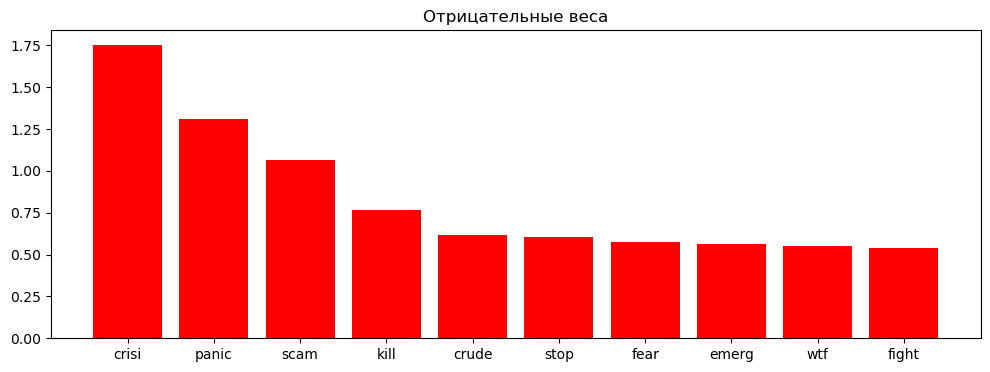

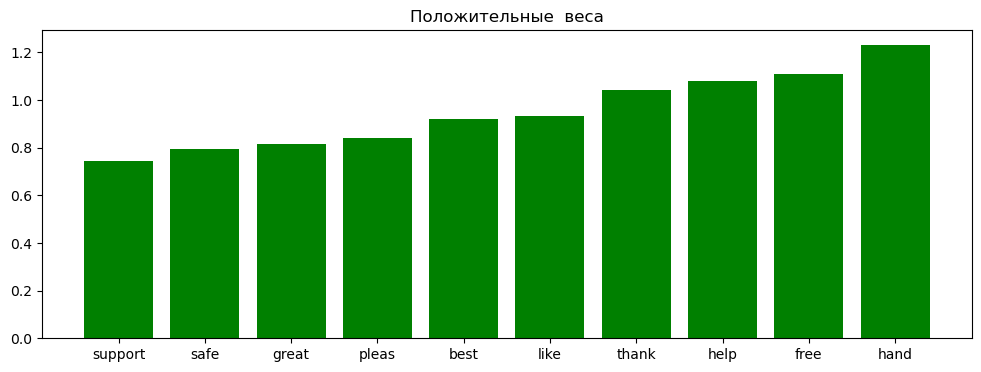

In [63]:
import matplotlib.pyplot as plt
feature_names = np.array(cv_df.get_feature_names_out())
sorted_coef_index = logreg_scaled.coef_[0].argsort()

plt.figure(figsize=(12, 4))
plt.bar(range(10), abs(logreg_scaled.coef_[0][sorted_coef_index[:10]]), color='r')
plt.xticks(range(10), feature_names[sorted_coef_index[:10]])
plt.title('Отрицательные веса')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(range(10), logreg_scaled.coef_[0][sorted_coef_index[-10:]], color='g')
plt.xticks(range(10), feature_names[sorted_coef_index[-10:]])
plt.title('Положительные  веса')
plt.show()

**Ответ:** Токены хорошо определились,чтобы делить твиты на положительные и отрицательные. С положительными весами слова, присущие позитивным твитам, а с отрицательными наоборот.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [64]:
len(df["UserName"].unique())

33444

In [65]:
len(df["ScreenName"].unique())

33444

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

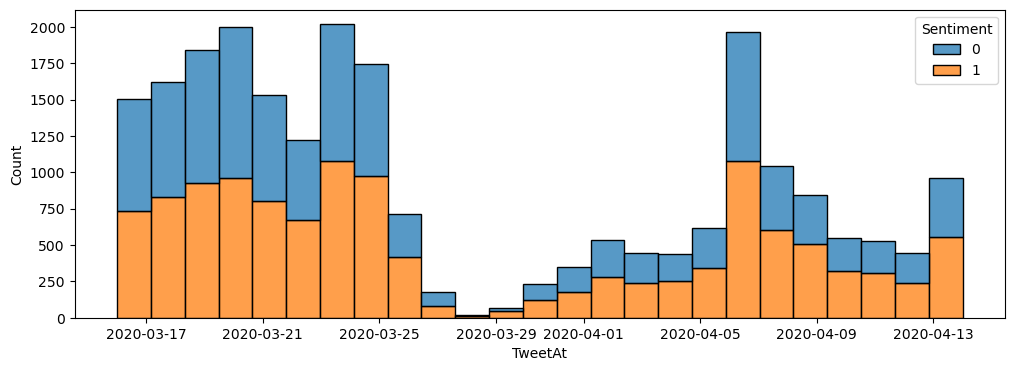

In [66]:
TweetAt = pd.to_datetime(train["TweetAt"], format="%d-%m-%Y")
data = pd.concat([TweetAt, y_train], axis=1)
plt.figure(figsize=(12, 4))
sns.histplot(data=data, x='TweetAt', hue="Sentiment", multiple="stack")
plt.show()

**Ответ:** Зависимость отрицательного или положительного твита от даты не прослеживается. Во всех датах положительных примерно вдвое меньше негативных.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [95]:
len(train["Location"].unique())

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [71]:
locations = train["Location"]
locations = locations[locations != "Unknown"]
locations = locations.value_counts().reset_index()
top_locations = locations.head(10)
top_locations

,Location,count
0,London,301
1,United States,295
2,"London, England",274
3,"New York, NY",223
4,"Washington, DC",222
5,United Kingdom,204
6,"Los Angeles, CA",154
7,India,153
8,UK,133
9,Australia,118


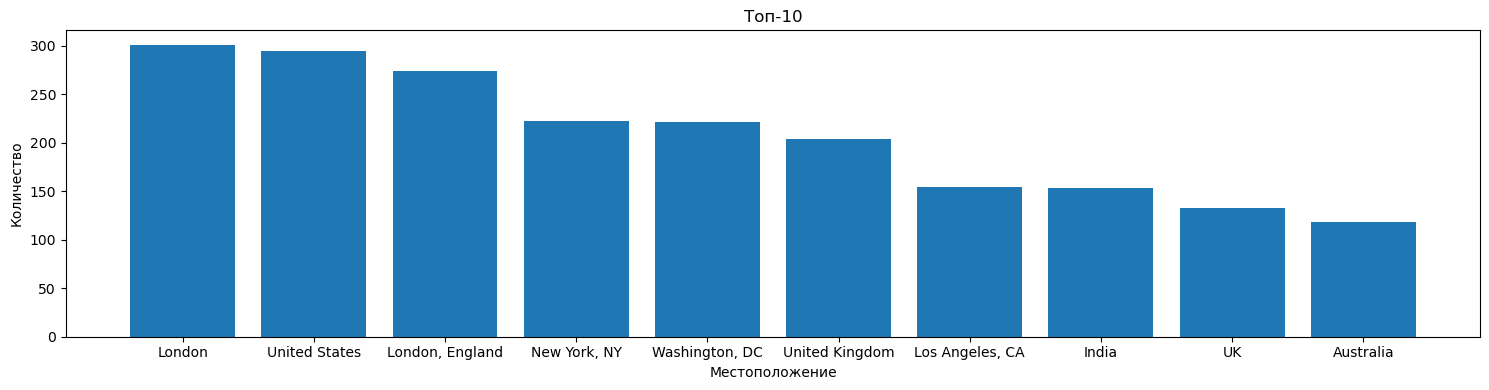

In [72]:
plt.figure(figsize=(15, 4))
plt.bar(top_locations['Location'], top_locations['count'])
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.title('Топ-10')
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [93]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(', ')[-1])

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,UK
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,Vagabonds
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1,Unknown
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,Unknown
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1,"ÃÂT: 36.319708,-82.363649"
...,...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1,OHIO
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1,Unknown
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...,0,Unknown
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1,Unknown


In [96]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(', ')[-1])

In [97]:
locations = train["WiderLocation"]
locations = locations[locations != "Unknown"]
locations = locations.value_counts().reset_index()
top_locations = locations.head(10)
top_locations

,WiderLocation,count
0,USA,950
1,England,860
2,CA,597
3,India,535
4,NY,392
5,UK,380
6,United Kingdom,376
7,London,375
8,United States,305
9,Canada,288


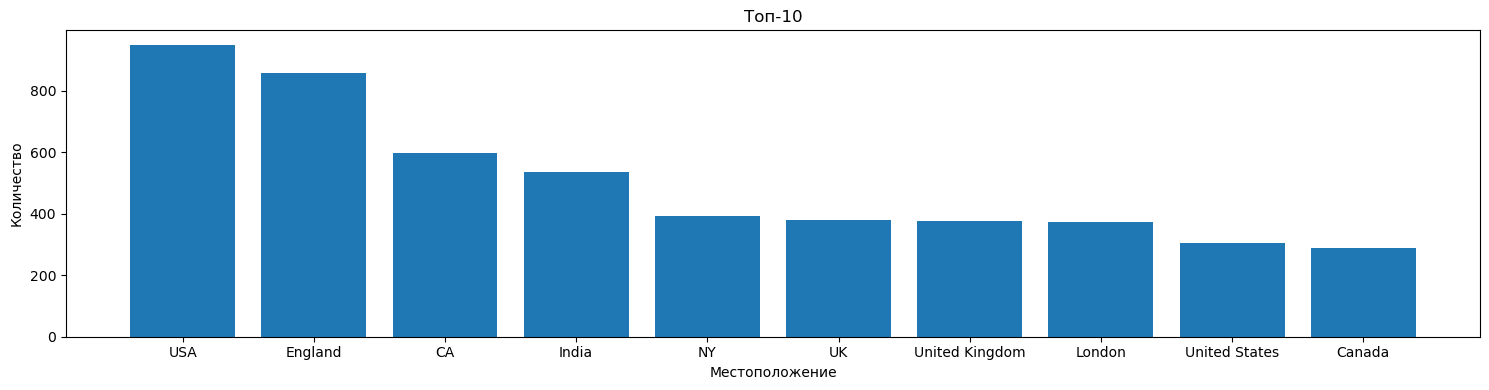

In [98]:
plt.figure(figsize=(15, 4))
plt.bar(top_locations['WiderLocation'], top_locations['count'])
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.title('Топ-10')
plt.tight_layout()
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [109]:
locations2 = df['WiderLocation'].value_counts()[df['WiderLocation'].value_counts() > 1].index
df['WiderLocation'] = df['WiderLocation'].apply(lambda x: x if x in locations2 else 'Other')
ohe_data = pd.get_dummies(df['WiderLocation'], prefix='WiderLocation')
ohe_data_train, ohe_data_test = train_test_split(ohe_data, test_size=0.3, random_state=0)
ohe_data.shape[1]

1355

По всему датасету таких 1355, в train 1011

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [110]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.toarray()))
X_test_scaled = pd.DataFrame(scaler.transform(X_test.toarray()))

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df['WiderLocation'] = df['WiderLocation'].astype('category')
encoder = OneHotEncoder(categories=[df['WiderLocation'].cat.categories], sparse=False)
ohe_feature = encoder.fit_transform(df[['WiderLocation']])
ohe_feature_train, ohe_feature_test = train_test_split(ohe_feature, test_size=0.3, random_state=0)
scaled_text_features_and_ohe_train = np.hstack((X_train_scaled, ohe_feature_train))
scaled_text_features_and_ohe_test = np.hstack((X_test_scaled, ohe_feature_test))

In [112]:
logreg = LogisticRegression()
logreg.fit(scaled_text_features_and_ohe_train, y_train)

y_pred = logreg.predict(scaled_text_features_and_ohe_test)

accuracy_with_ohe = accuracy_score(y_test, y_pred)
accuracy_with_ohe

0.8453258919673111

**Ответ:** Качество совсем немного улучшилось, сложно назвать признак полезным

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --